# Datasets comparison between CAMS and TROPOMI (L2)

## Imports and supporting functions

In [1]:
# Related to the system
import os 

# Related to the data retrieval
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import geojson
import urllib3

# Related to the data analysis
import math
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
from itertools import product
import scipy.interpolate
from scipy.spatial.distance import cdist
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Related to the results
from copy import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import geocoder
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML, display
import warnings

In [2]:
%run functions/functions_general.ipynb
%run functions/functions_cams.ipynb
%run functions/functions_tropomi.ipynb

In [3]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

# Hide API request warning
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Increase animation limit
matplotlib.rcParams['animation.embed_limit'] = 25000000

# Hide labels animation warning
warnings.filterwarnings('ignore', category = UserWarning, module='cartopy')

## 1. Define datasets

In [4]:
# Define component (NO2, CO, O3, SO2 or HCHO)
component_nom = 'NO2'

# Define model
model = 'cams'
model_full_name = 'cams-global-atmospheric-composition-forecasts'

# Define sensor
sensor = 'tropomi'
sensor_type = 'L2'
apply_kernels = False

# Define search period
start_date = '2021-11-18'
end_date = '2021-11-18'

# Define extent
area_name = 'Barcelona'
lon_min = 0
lon_max = 4
lat_min = 40
lat_max = 43

In [5]:
# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name, sensor_type, apply_kernels)

# Get component full name and molecular weight
component, component_MW, product_type, sensor_column, column_type = components_table(sensor, component_nom, sensor_type)

# Folders generation
generate_folders(model, sensor, component_nom, sensor_type)

The comparison is possible and will start now.


In [6]:
# Generate array with search dates
dates = search_period(start_date, end_date, sensor, sensor_type)

# Create bbox
bbox = search_bbox(lon_min, lat_min, lon_max, lat_max)

SEARCH PERIOD
- In days: [('2021-11-18T00:00:00Z', '2021-11-18T23:00:00Z')]
SEARCH BOUNDING BOX
Latitudes: from 40 to 43
Longitudes: from 0 to 4


## 2. Model data

### Download and read data as xarray

In [7]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, 
                                               lat_min, lat_max, lon_min, lon_max, area_name, model_full_name, 
                                               model_level = 'multiple', CAMS_UID = None, CAMS_key = None)

The file exists, it will not be downloaded again.


In [8]:
model_ds, _, model_levels_df = CAMS_read(model_product_name, component, component_nom, dates)
model_ds

<xarray.Dataset>
Dimensions:     (hybrid: 137, latitude: 8, longitude: 11, step: 8, time: 1)
Coordinates:
  * time        (time) datetime64[ns] 2021-11-18
  * step        (step) timedelta64[ns] 00:00:00 03:00:00 ... 18:00:00 21:00:00
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * latitude    (latitude) float64 40.0 40.4 40.8 41.2 41.6 42.0 42.4 42.8
  * longitude   (longitude) float64 0.0 0.4 0.8 1.2 1.6 2.0 2.4 2.8 3.2 3.6 4.0
    valid_time  (step) datetime64[ns] ...
Data variables:
    component   (time, step, hybrid, latitude, longitude) float32 3.868e-09 ....
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-01-30T11:01 GRIB to CDM+CF via cfgrib-0.9.9...

### Collect 137 levels model data

In [9]:
model_levels_df

,a [Pa],b,ph [hPa],pf [hPa],Geopotential Altitude [m],Geometric Altitude [m],Temperature [K],Density [kg/m^3],ph [Pa],Depth [m]
hybrid,,,,,,,,,,
1,2.000365,0.000000,0.0200,0.0100,79301.79,80301.65,198.05,0.000018,2.00,5580.21
2,3.102241,0.000000,0.0310,0.0255,73721.58,74584.91,209.21,0.000042,3.10,2605.83
3,4.666084,0.000000,0.0467,0.0388,71115.75,71918.79,214.42,0.000063,4.67,2497.32
4,6.827977,0.000000,0.0683,0.0575,68618.43,69365.77,221.32,0.000090,6.83,2407.44
5,9.746966,0.000000,0.0975,0.0829,66210.99,66906.53,228.06,0.000127,9.75,2320.96
...,...,...,...,...,...,...,...,...,...,...
133,62.781250,0.988500,1002.2250,1000.5165,106.54,106.54,287.46,1.212498,100222.50,27.50
134,22.835938,0.991984,1005.3562,1003.7906,79.04,79.04,287.64,1.215710,100535.62,25.12
135,3.757813,0.995003,1008.2239,1006.7900,53.92,53.92,287.80,1.218650,100822.39,22.96


### Convert CAMS data units

In [10]:
model_ds, units = model_convert_units(model, model_ds, sensor, 
                                      component_MW, model_levels_df,
                                      start_date, end_date, component_nom, apply_kernels,
                                      CAMS_UID = None, CAMS_key = None)

The model component units have been converted from kg kg**-1 to kg m**-2.
The model component units have been converted from kg m**-2 to molec cm-2.


### Get CAMS levels (total or tropospheric)

In [11]:
model_ds = CAMS_get_levels_data(model_ds, model_product_name, model_levels_df, 
                                column_type, lat_min, lat_max, lon_min, lon_max)
model_ds

2022-01-30 11:01:29,847 INFO Welcome to the CDS
2022-01-30 11:01:29,848 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-atmospheric-composition-forecasts
2022-01-30 11:01:29,938 INFO Request is completed
2022-01-30 11:01:29,940 INFO Downloading https://download-0000.copernicus-atmosphere.eu/cache-compute-0000/cache/data9/adaptor.mars_constrained.external-1643488665.6678581-18039-11-f729da99-0747-423e-a45c-7d513bdb4057.grib to /home/alba/adc-toolbox/data/cams/NO2/CAMS_FORECAST_SURFACE_PRESSURE_2021-11-18_2021-11-18_Barcelona.grib (2.2K)


The model tropospheric columns will be compared to the tropospheric sensor columns.
The model tropospheric columns will be estimated (pressures above or equal to 300 hPa).


2022-01-30 11:01:30,189 INFO Download rate 8.9K/s
2022-01-30 11:01:30,200 WARNING Ignoring index file '/home/alba/adc-toolbox/data/cams/NO2/CAMS_FORECAST_SURFACE_PRESSURE_2021-11-18_2021-11-18_Barcelona.grib.923a8.idx' older than GRIB file


<xarray.Dataset>
Dimensions:     (latitude: 8, longitude: 11, step: 8, time: 1)
Coordinates:
  * time        (time) datetime64[ns] 2021-11-18
  * step        (step) timedelta64[ns] 00:00:00 03:00:00 ... 18:00:00 21:00:00
  * latitude    (latitude) float64 40.0 40.4 40.8 41.2 41.6 42.0 42.4 42.8
  * longitude   (longitude) float64 0.0 0.4 0.8 1.2 1.6 2.0 2.4 2.8 3.2 3.6 4.0
    valid_time  (step) datetime64[ns] 2021-11-18 ... 2021-11-18T21:00:00
Data variables:
    component   (time, step, latitude, longitude) float64 5.005e+15 ... 3.833...
    pressure    (time, step, latitude, longitude) float64 3.943e+06 ... 4.035...

### Download read and subset original total columns data

In [12]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, 
                                               lat_min, lat_max, lon_min, lon_max, area_name, model_full_name, 
                                               model_level = 'single', CAMS_UID = None, CAMS_key = None)

The file exists, it will not be downloaded again.


In [13]:
model_total_ds, _, _ = CAMS_read(model_product_name, component, component_nom, dates)
model_total_ds

<xarray.Dataset>
Dimensions:     (latitude: 8, longitude: 11, step: 8, time: 1)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2021-11-18
  * step        (step) timedelta64[ns] 00:00:00 03:00:00 ... 18:00:00 21:00:00
    surface     float64 ...
  * latitude    (latitude) float64 40.0 40.4 40.8 41.2 41.6 42.0 42.4 42.8
  * longitude   (longitude) float64 0.0 0.4 0.8 1.2 1.6 2.0 2.4 2.8 3.2 3.6 4.0
    valid_time  (step) datetime64[ns] ...
Data variables:
    component   (time, step, latitude, longitude) float32 7.118e-06 ... 5.775...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-01-30T11:01 GRIB to CDM+CF via cfgrib-0.9.9...

### Convert CAMS total columns data units

In [14]:
model_total_ds, _ = model_convert_units(model, model_total_ds, sensor,
                                        component_MW, model_levels_df,
                                        start_date, end_date, component_nom, apply_kernels,
                                        CAMS_UID = None, CAMS_key = None)

The model component units have been converted from kg m**-2 to molec cm-2.


## 3. Sensor data

### Download and read data as xarray

In [15]:
dates = sensor_download(sensor, sensor_type, component_nom, dates, bbox, product_type)

RESULTS
For ('2021-11-18T00:00:00Z', '2021-11-18T23:00:00Z'):
You can see all the results at https://s5phub.copernicus.eu/dhus/.


2022-01-30 11:01:31,795 INFO Found 0 products
2022-01-30 11:01:31,888 INFO Found 1 products


There are no results for the processing mode NRT. The search in the offline archives will start.
Number 0-S5P_OFFL_L2__NO2____20211118T112150_20211118T130320_21240_02_020301_20211120T033928
SELECTED
File name: c0858e18-3e8d-4885-8cf1-9c57236d07e7
Product name: S5P_OFFL_L2__NO2____20211118T112150_20211118T130320_21240_02_020301_20211120T033928.nc
The file exists, it will not be downloaded again.


In [16]:
sensor_ds, support_input_ds, support_details_ds = sensor_read(sensor, sensor_type, sensor_column, 
                                                              component_nom, dates)
sensor_ds

<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 4173, time: 1, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    sensor_column                                         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    averaging_kernel                                      (time, scanline, ground_pixel, layer) float32 ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (time, layer, vertices) float32 ...
    tm5_constant_b                                        (time, layer, vertices) float32 ...

In [17]:
support_input_ds

<xarray.Dataset>
Dimensions:                                (ground_pixel: 450, scanline: 4173, time: 1)
Coordinates:
  * time                                   (time) datetime64[ns] 2021-11-18
  * scanline                               (scanline) float64 0.0 ... 4.172e+03
  * ground_pixel                           (ground_pixel) float64 0.0 ... 449.0
Data variables: (12/18)
    surface_altitude                       (time, scanline, ground_pixel) float32 ...
    surface_altitude_precision             (time, scanline, ground_pixel) float32 ...
    surface_classification                 (time, scanline, ground_pixel) float32 ...
    instrument_configuration_identifier    (time, scanline) float64 20.0 ... ...
    instrument_configuration_version       (time, scanline) float32 24.0 ... ...
    scaled_small_pixel_variance            (time, scanline, ground_pixel) float32 ...
    ...                                     ...
    cloud_fraction_crb                     (time, scanline, ground_pixel) float32 ...
    cloud_albedo_crb                       (time, scanline, ground_pixel) float32 ...
    scene_albedo                           (time, scanline, ground_pixel) float32 ...
    apparent_scene_pressure                (time, scanline, ground_pixel) float32 ...
    snow_ice_flag                          (time, scanline, ground_pixel) float32 ...
    aerosol_index_354_388                  (time, scanline, ground_pixel) float32 ...

In [18]:
support_details_ds

<xarray.Dataset>
Dimensions:                                                (ground_pixel: 450, intensity_offset_polynomial_exponents: 1, polynomial_exponents: 6, scanline: 4173, time: 1)
Coordinates:
  * time                                                   (time) datetime64[ns] ...
  * scanline                                               (scanline) float64 ...
  * ground_pixel                                           (ground_pixel) float64 ...
Dimensions without coordinates: intensity_offset_polynomial_exponents, polynomial_exponents
Data variables: (12/45)
    processing_quality_flags                               (time, scanline, ground_pixel) float64 ...
    number_of_spectral_points_in_retrieval                 (time, scanline, ground_pixel) float32 ...
    number_of_iterations                                   (time, scanline, ground_pixel) float64 ...
    wavelength_calibration_offset                          (time, scanline, ground_pixel) float32 ...
    wavelength_calibration_offset_precision                (time, scanline, ground_pixel) float32 ...
    wavelength_calibration_stretch                         (time, scanline, ground_pixel) float32 ...
    ...                                                     ...
    degrees_of_freedom                                     (time, scanline, ground_pixel) float32 ...
    air_mass_factor_stratosphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_cloudy                                 (time, scanline, ground_pixel) float32 ...
    air_mass_factor_clear                                  (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_ghost_column                           (time, scanline, ground_pixel) float32 ...
    cloud_selection_flag                                   (time, scanline, ground_pixel) float32 ...

### Convert TROPOMI data units (From mol/m<sup>2</sup> to molecules/cm<sup>2</sup>)

In [19]:
sensor_ds = sensor_convert_units(sensor_ds, sensor, component_nom)
sensor_ds

The sensor component units have been converted from mol m-2 to molec cm-2.


<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 4173, time: 1, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    sensor_column                                         (time, scanline, ground_pixel) float64 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    averaging_kernel                                      (time, scanline, ground_pixel, layer) float32 ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (time, layer, vertices) float32 ...
    tm5_constant_b                                        (time, layer, vertices) float32 ...

## 4. Match data

In [20]:
match_df = generate_match_df(sensor_ds, model_ds, bbox, sensor, component_nom, sensor_type, apply_kernels)
match_df

FOR DATE: 2021-11-18
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.


layer              delta_time   latitude  \
scanline ground_pixel time                                                   
3267.0   77.0         2021-11-18    0.0 2021-11-18 12:29:09.571  38.855568   
         78.0         2021-11-18    0.0 2021-11-18 12:29:09.571  38.881218   
         79.0         2021-11-18    0.0 2021-11-18 12:29:09.571  38.906555   
         80.0         2021-11-18    0.0 2021-11-18 12:29:09.571  38.931576   
         81.0         2021-11-18    0.0 2021-11-18 12:29:09.571  38.956295   
...                                 ...                     ...        ...   
3344.0   157.0        2021-11-18    0.0 2021-11-18 12:30:14.249  43.975159   
         158.0        2021-11-18    0.0 2021-11-18 12:30:14.249  43.987720   
         159.0        2021-11-18    0.0 2021-11-18 12:30:14.249  44.000195   
         160.0        2021-11-18    0.0 2021-11-18 12:30:14.249  44.012585   
         161.0        2021-11-18    0.0 2021-11-18 12:30:14.249  44.024887   

                                  longitude  qa_value  sensor_column  \
scanline ground_pixel time                                             
3267.0   77.0         2021-11-18   0.536606      1.00   2.185018e+15   
         78.0         2021-11-18   0.605027      1.00   2.239676e+15   
         79.0         2021-11-18   0.672876      1.00   2.466516e+15   
         80.0         2021-11-18   0.740167      1.00   2.610684e+15   
         81.0         2021-11-18   0.806910      0.74   1.655611e+15   
...                                     ...       ...            ...   
3344.0   157.0        2021-11-18   3.336593      1.00   1.150485e+15   
         158.0        2021-11-18   3.384023      1.00   1.134583e+15   
         159.0        2021-11-18   3.431328      1.00   1.897351e+15   
         160.0        2021-11-18   3.478508      1.00   9.255121e+14   
         161.0        2021-11-18   3.525568      1.00  -6.121179e+14   

                                  nitrogendioxide_tropospheric_column_precision  \
scanline ground_pixel time                                                        
3267.0   77.0         2021-11-18                                       0.000011   
         78.0         2021-11-18                                       0.000011   
         79.0         2021-11-18                                       0.000014   
         80.0         2021-11-18                                       0.000014   
         81.0         2021-11-18                                       0.000011   
...                                                                         ...   
3344.0   157.0        2021-11-18                                       0.000017   
         158.0        2021-11-18                                       0.000018   
         159.0        2021-11-18                                       0.000019   
         160.0        2021-11-18                                       0.000016   
         161.0        2021-11-18                                       0.000016   

                                  nitrogendioxide_tropospheric_column_precision_kernel  \
scanline ground_pixel time                                                               
3267.0   77.0         2021-11-18                                           0.000008      
         78.0         2021-11-18                                           0.000008      
         79.0         2021-11-18                                           0.000011      
         80.0         2021-11-18                                           0.000010      
         81.0         2021-11-18                                           0.000009      
...                                                                             ...      
3344.0   157.0        2021-11-18                                           0.000017      
         158.0        2021-11-18                                           0.000018      
         159.0        2021-11-18                                           0.000018      
         160

## 5. Merge data and calculate difference

In [21]:
merge_df = generate_merge_df(match_df, sensor_ds, model_ds, sensor, apply_kernels)
merge_df

latitude  longitude  model_column  \
scanline ground_pixel time                                             
3267.0   77.0         2021-11-18  38.855568   0.536606  9.644927e+14   
         78.0         2021-11-18  38.881218   0.605027  1.241963e+15   
         79.0         2021-11-18  38.906555   0.672876  1.241963e+15   
         80.0         2021-11-18  38.931576   0.740167  1.241963e+15   
         81.0         2021-11-18  38.956295   0.806910  1.241963e+15   
...                                     ...        ...           ...   
3344.0   157.0        2021-11-18  43.975159   3.336593  1.591320e+15   
         158.0        2021-11-18  43.987720   3.384023  1.591320e+15   
         159.0        2021-11-18  44.000195   3.431328  1.747864e+15   
         160.0        2021-11-18  44.012585   3.478508  1.747864e+15   
         161.0        2021-11-18  44.024887   3.525568  1.747864e+15   

                                  sensor_column    difference  \
scanline ground_pixel time                                      
3267.0   77.0         2021-11-18   2.185018e+15 -1.220525e+15   
         78.0         2021-11-18   2.239676e+15 -9.977122e+14   
         79.0         2021-11-18   2.466516e+15 -1.224553e+15   
         80.0         2021-11-18   2.610684e+15 -1.368720e+15   
         81.0         2021-11-18   1.655611e+15 -4.136471e+14   
...                                         ...           ...   
3344.0   157.0        2021-11-18   1.150485e+15  4.408350e+14   
         158.0        2021-11-18   1.134583e+15  4.567362e+14   
         159.0        2021-11-18   1.897351e+15 -1.494871e+14   
         160.0        2021-11-18   9.255121e+14  8.223515e+14   
         161.0        2021-11-18  -6.121179e+14  2.359982e+15   

                                  relative_difference  
scanline ground_pixel time                             
3267.0   77.0         2021-11-18            -0.558588  
         78.0         2021-11-18            -0.445472  
         79.0         2021-11-18            -0.496471  
         80.0         2021-11-18            -0.524277  
         81.0         2021-11-18            -0.249846  
...                                               ...  
3344.0   157.0        2021-11-18             0.383173  
         158.0        2021-11-18             0.402559  
         159.0        2021-11-18            -0.078787  
         160.0        2021-11-18             0.888537  
         161.0        2021-11-18            -3.855436  

[6630 rows x 6 columns]

In [22]:
descr_stats_table = merge_df.describe()
descr_stats_table

,latitude,longitude,model_column,sensor_column,difference,relative_difference
count,6630.000000,6630.000000,6.630000e+03,6.625000e+03,6.625000e+03,6625.000000
mean,41.522152,2.150548,1.458809e+15,2.509182e+15,-1.049920e+15,-0.306462
std,1.162094,1.416012,8.567338e+14,1.244666e+15,1.099466e+15,1.528033
min,38.855568,-1.203787,7.411226e+14,-7.878413e+14,-1.256764e+16,-31.389468
25%,40.582954,1.025037,1.005305e+15,1.708407e+15,-1.642739e+15,-0.585255
50%,41.521982,2.229298,1.217449e+15,2.308055e+15,-9.417376e+14,-0.421008
75%,42.456593,3.313953,1.591320e+15,3.052502e+15,-3.450613e+14,-0.199575
max,44.024887,5.033311,7.067152e+15,1.765394e+16,3.447489e+15,78.452821


## 6. Show comparison plots

### Select plot dates

In [23]:
plot_dates = plot_period(sensor_ds, sensor_type)

The plots will be shown for the following dates:
['2021-11-18']


### Select plot extent

In [24]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((0, 40), (4, 43))


### Compare CAMS and TROPOMI total columns

Frame length between 0 and 4 should be one of these options: [1, 2, 4]
Frame length between 40 and 43 should be one of these options: [1, 3]


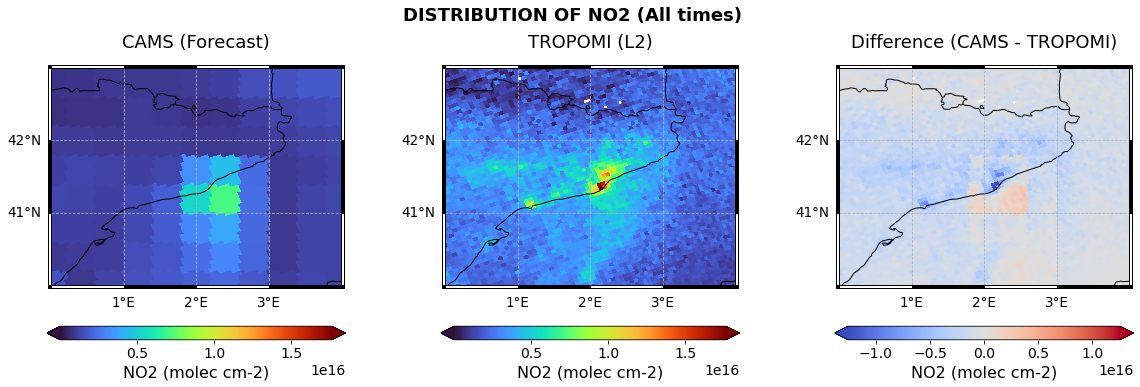

In [25]:
# Choose distribution (aggregated, individual or animated)
plot_type = 'aggregated'

# Define range (original, equal, centered or manual)
range_type = 'equal'
vmin_manual, vmax_manual = None, None
vmin_manual_diff, vmax_manual_diff = None, None

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale = ['turbo', 'turbo', 'coolwarm']

# Get and decide the best width and height of the B/W frame lines
options_height_lon = get_frame_possible_lengths(lon_min, lon_max)
options_width_lat = get_frame_possible_lengths(lat_min, lat_max)
width_lon = 1
height_lat = 1

visualize_model_vs_sensor(model, sensor, component_nom, units, merge_df, plot_dates, plot_bbox, 20, 1.05, 
                          model_type, sensor_type, range_type, plot_type, projection,
                          color_scale, width_lon, height_lat, vmin_manual, vmax_manual,
                          vmin_manual_diff, vmax_manual_diff,
                          bbox_list = None, coords_list = None, regions_names = None)

### Compare CAMS original and averaged total columns

Frame length between 0 and 4 should be one of these options: [1, 2, 4]
Frame length between 40 and 43 should be one of these options: [1, 3]


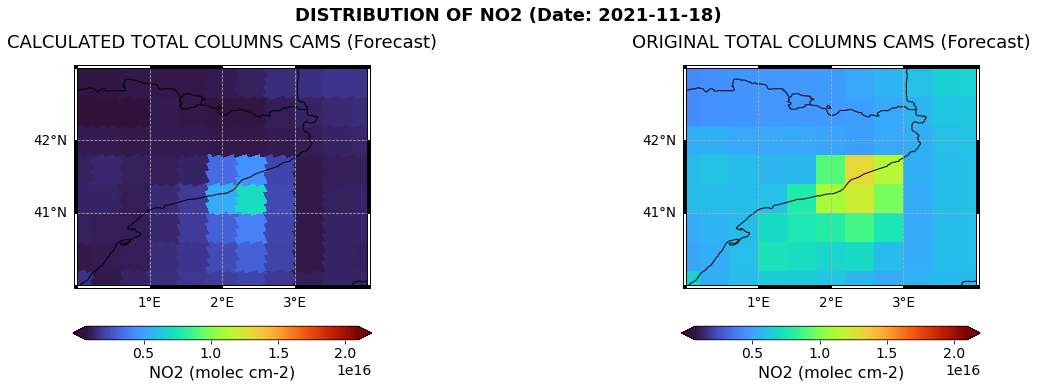

In [26]:
# Define range (original, equal, centered or manual)
range_type = 'equal' # original or equal
vmin_manual = None
vmax_manual = None

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale = ['turbo', 'turbo']

# Get and decide the best width and height of the B/W frame lines
options_height_lon = get_frame_possible_lengths(lon_min, lon_max)
options_width_lat = get_frame_possible_lengths(lat_min, lat_max)
width_lon = 1
height_lat = 1

visualize_model_original_vs_calculated(model, component_nom, units, merge_df, model_total_ds, plot_dates, 
                                       plot_bbox, 20, 1.05, model_type, range_type, projection, color_scale,
                                       width_lon, height_lat, vmin_manual, vmax_manual)

## 7. Retrieve nearest values to specific coordinates

In [27]:
regions_names = ('Barcelona - 1', 'Barcelona - 2')
coords_list = (41.39, 2.15,
               41.1, 1.65)
ymin = 0
ymax = 5*10**15
xticks = plot_dates

timeseries_table = timeseries(merge_df, component_nom, sensor, sensor_type, model, 
                              plot_dates, units, ymin, ymax, xticks, regions_names, coords_list)
timeseries_table

,,,,,,scanline,ground_pixel,model_column,sensor_column,difference,relative_difference
region,lat_search,lon_search,latitude,longitude,time,,,,,,
Barcelona - 1,41.39,2.15,41.399746,2.131355,2021-11-18,3303.0,116.0,5.345844e+15,1.711462e+16,-1.176877e+16,-0.687645
Barcelona - 2,41.10,1.65,41.075066,1.639530,2021-11-18,3300.0,106.0,1.908313e+15,3.974105e+15,-2.065792e+15,-0.519813


## 8. Scatter plots by bbox

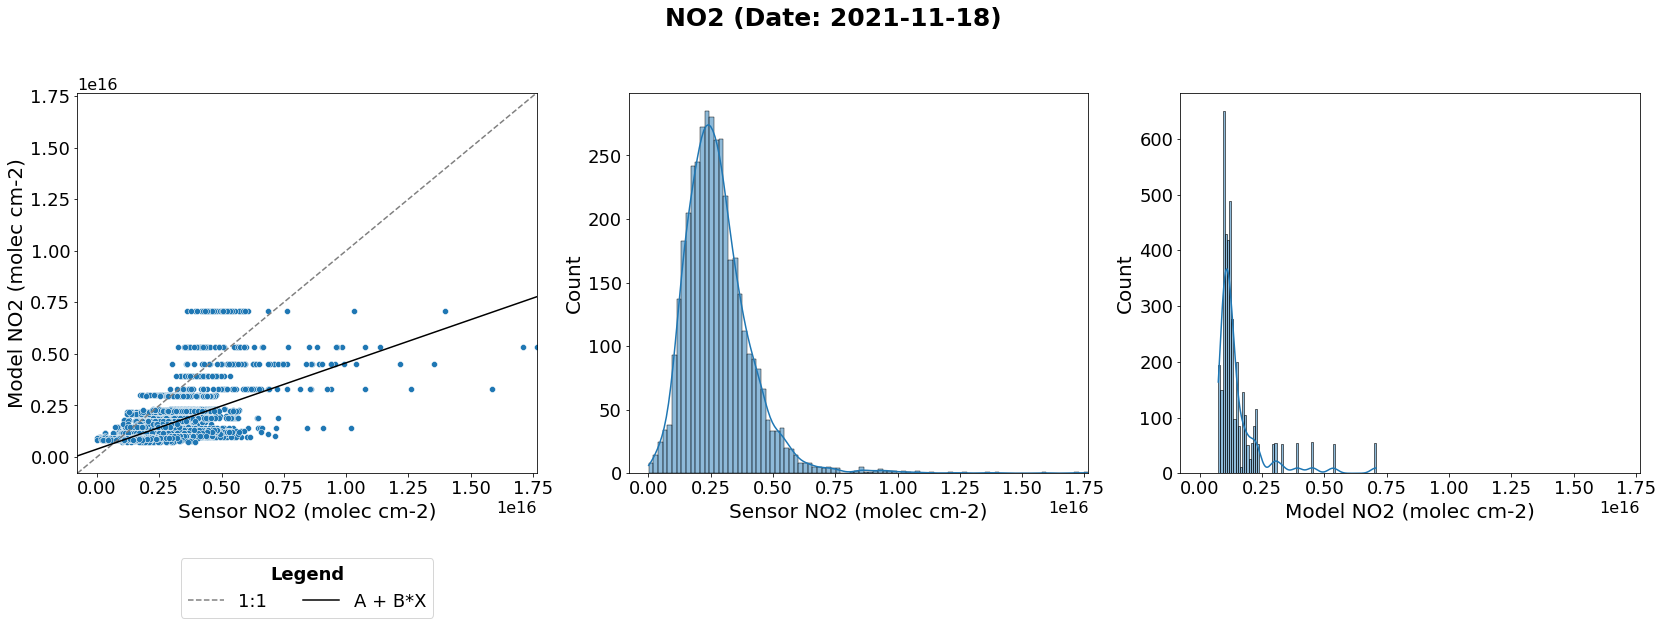

,Period,Location,A,B,R2,RMSE,MSE
0,2021-11-18,"((0, 40), (4, 43))",0.418397,3.835155e+14,0.304053,8.809907e+14,7.761446e+29


In [28]:
show_seasons = False
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_df, component_nom, units, sensor, plot_dates, 1.05, 
                       extent_definition, show_seasons, scatter_plot_type, 
                       lim_min, lim_max, plot_bbox)
summary

## 9. Scatter plots by season

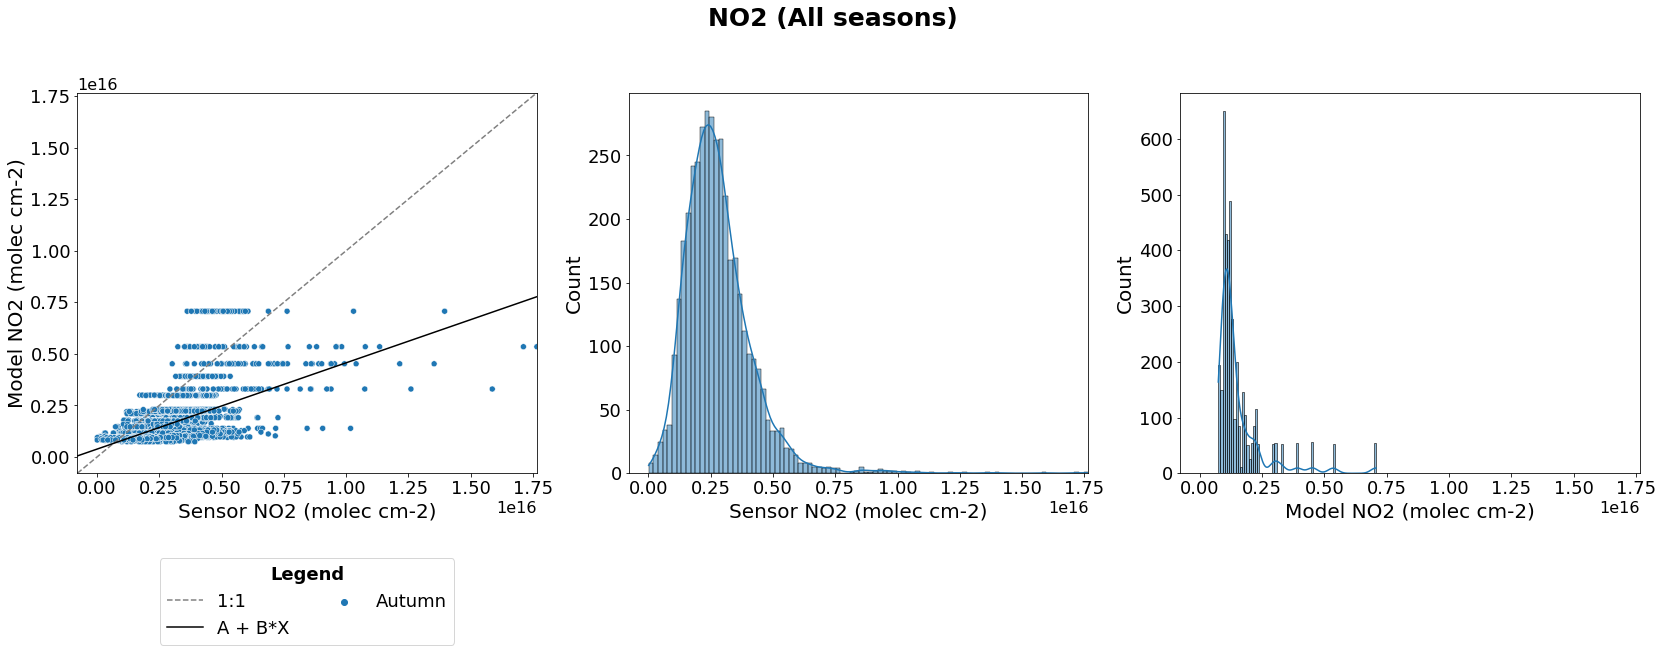

,Period,Location,A,B,R2,RMSE,MSE
0,[Autumn],"((0, 40), (4, 43))",0.418397,3.835155e+14,0.304053,8.809907e+14,7.761446e+29


In [29]:
show_seasons = True
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_df, component_nom, units, sensor, plot_dates, 1.05, 
                       extent_definition, show_seasons, scatter_plot_type, 
                       lim_min, lim_max, plot_bbox)
summary

## 10. Scatter plots by country (Google API required!)

In [30]:
"""
show_seasons = False
extent_definition = 'country' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual
plot_countries = ['Czech Republic', 'Poland', 'Germany']

lim_min = None
lim_max = None

summary = scatter_plot(merge_df, component_nom, units, sensor, plot_dates, 1.05, 
                       extent_definition, show_seasons, scatter_plot_type, 
                       lim_min, lim_max, plot_countries)
summary
"""

"\nshow_seasons = False\nextent_definition = 'country' # bbox or country\nscatter_plot_type = 'aggregated' # aggregated or individual\nplot_countries = ['Czech Republic', 'Poland', 'Germany']\n\nlim_min = None\nlim_max = None\n\nsummary = scatter_plot(merge_df, component_nom, units, sensor, plot_dates, 1.05, \n                       extent_definition, show_seasons, scatter_plot_type, \n                       lim_min, lim_max, plot_countries)\nsummary\n"